In [33]:
import pandas as pd
from glob import glob
import librosa as lr
import numpy as np
import matplotlib.pyplot as plt

#### Inspecting the classification data
- The first is a collection of heartbeat sounds. Hearts normally have a predictable sound pattern as they beat, but some disorders can cause the heart to beat abnormally.

In [29]:
train_set = '../data/set_b/'
train_files = glob(train_set+'*.wav')
# include only normal and murmur
train_files = [file for file in train_files if 'normal' in file or 'murmur' in file]
# filter noisy normal and noisy murmur
audio_files = [file for file in train_files if not 'noisymurmur' in file or 'nosiynormal' in file]
audio_files[:10]

['../data/set_b\\murmur__112_1306243000964_A.wav',
 '../data/set_b\\murmur__112_1306243000964_B.wav',
 '../data/set_b\\murmur__112_1306243000964_D.wav',
 '../data/set_b\\murmur__116_1306258689913_A.wav',
 '../data/set_b\\murmur__116_1306258689913_C.wav',
 '../data/set_b\\murmur__116_1306258689913_D.wav',
 '../data/set_b\\murmur__122_1306325762831_C.wav',
 '../data/set_b\\murmur__122_1306325762831_D.wav',
 '../data/set_b\\murmur__156_1306936373241_B.wav',
 '../data/set_b\\murmur__160_1307100683334_A.wav']

In [32]:
# Read in the first audio file, create the time array
audio, sfreq = lr.load(audio_files[0])
time = np.arange(0, len(audio)) / sfreq

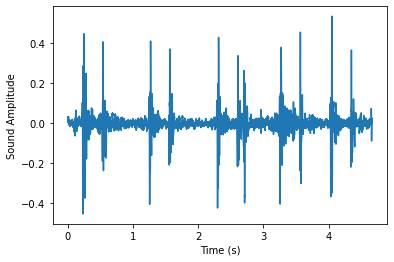

In [34]:
# Plot audio over time
fig, ax = plt.subplots()
ax.plot(time,audio)
ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')
plt.show()

##### Conclusion : There are several seconds of heartbeat sounds in here, though note that most of this time is silence. A common procedure in machine learning is to separate the datapoints with lots of stuff happening from the ones that don't.

### Inspecting the regression data
- dataset contains information about company market value over several years of time. This is one of the most popular kind of time series data used for regression. If we can model the value of a company as it changes over time, we can make predictions about where that company will be in the future.

In [79]:
# Read in the data
data = pd.read_csv('../data/prices.csv', index_col=0)
data_1 = data[data['symbol'].str.contains('V')]
data_2 = data[data['symbol'].str.contains('AAPL')]
data_3 = data[data['symbol'].str.contains('NFLX')]
data_4 = data[data['symbol'].str.contains('XOM')]
# data_5 = data[data['symbol'].str.contains('FB')]
data = pd.concat([data_1, data_2, data_3, data_4], axis=0)
print(data.symbol.unique())
data = data.drop(['volume'], axis=1)
data.head()

['NVDA' 'V' 'VZ' 'AAPL' 'NFLX' 'XOM']


,symbol,close
date,,
2010-01-04,NVDA,18.490000
2010-01-04,V,88.139999
2010-01-04,VZ,33.279869
2010-01-05,NVDA,18.760000
2010-01-05,V,87.129997


In [82]:
data = data.pivot_table('close','date', 'symbol')
data

symbol,AAPL,NFLX,NVDA,V,VZ,XOM
date,,,,,,
2010-01-04,214.009998,53.479999,18.490000,88.139999,33.279869,69.150002
2010-01-05,214.379993,51.510001,18.760000,87.129997,33.339868,69.419998
2010-01-06,210.969995,53.319999,18.879999,85.959999,31.919873,70.019997
2010-01-07,210.580000,52.400001,18.510000,86.760002,31.729875,69.800003
2010-01-08,211.980005,53.300002,18.549999,87.000000,31.749874,69.519997
...,...,...,...,...,...,...
2016-12-23,116.519997,125.589996,109.779999,78.150002,53.680000,90.709999
2016-12-27,117.260002,128.350006,117.320000,78.349998,53.639999,90.750000
2016-12-28,116.760002,125.889999,109.250000,78.300003,53.439999,90.300003


symbol            AAPL       NFLX       NVDA          V         VZ        XOM
date                                                                         
2010-01-04  214.009998  53.479999  18.490000  88.139999  33.279869  69.150002
2010-01-05  214.379993  51.510001  18.760000  87.129997  33.339868  69.419998
2010-01-06  210.969995  53.319999  18.879999  85.959999  31.919873  70.019997
2010-01-07  210.580000  52.400001  18.510000  86.760002  31.729875  69.800003
2010-01-08  211.980005  53.300002  18.549999  87.000000  31.749874  69.519997
AAPL
NFLX
NVDA
V
VZ
XOM


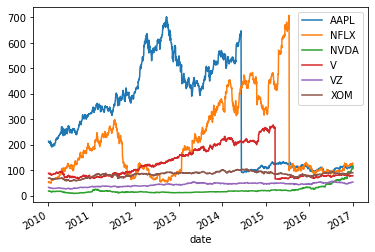

In [83]:
# Convert the index of the DataFrame to datetime
data.index = pd.to_datetime(data.index)
print(data.head())

# Loop through each column, plot its values over time
fig, ax = plt.subplots()
for column in data.columns:
    print(column)
    data[column].plot(ax=ax, label=column)
ax.legend()
plt.show()

##### Conclusion : Note that each company's value is sometimes correlated with others, and sometimes not. Also note there are a lot of 'jumps' in there - what effect do we think these jumps would have on a predictive model?

### Simple classification
- start with perhaps the simplest classification technique: averaging across dimensions of a dataset and visually inspecting the result.
- use the heartbeat data.Some recordings are normal heartbeat activity, while others are abnormal activity. Let's see if we can spot the difference.

In [84]:
with pd.HDFStore('../data/audio_munged.hdf5') as hdf:
    # This prints a list of all group names:
    print(hdf.keys())

['/h5io/key_data', '/h5io/key_meta']


In [85]:
df = pd.read_hdf('../data/audio_munged.hdf5', '/h5io/key_data')
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
time,,,,,,,,,,,,,,,,,,,,,
0.000000,-0.024684,-0.024507,0.008254,-0.000995,0.000281,-0.030747,0.002953,0.005497,-0.000950,0.013836,...,0.073388,0.008799,-0.361737,-0.000501,0.025458,-0.001609,-0.005471,-0.003371,-0.003332,-0.005799
0.000454,-0.060429,-0.047736,0.014809,-0.003381,0.000381,-0.060250,0.003034,0.010088,-0.003243,0.036587,...,0.150714,0.017107,-0.651842,-0.004710,0.053362,-0.004319,-0.011112,-0.004309,-0.007769,-0.010838


In [87]:
normal = df[[3,4,6]]
normal.head(2)

,3,4,6
time,,,
0.000000,-0.000995,0.000281,0.002953
0.000454,-0.003381,0.000381,0.003034


In [88]:
abnormal = df[[0,1,2]]
abnormal.head(2)

,0,1,2
time,,,
0.000000,-0.024684,-0.024507,0.008254
0.000454,-0.060429,-0.047736,0.014809


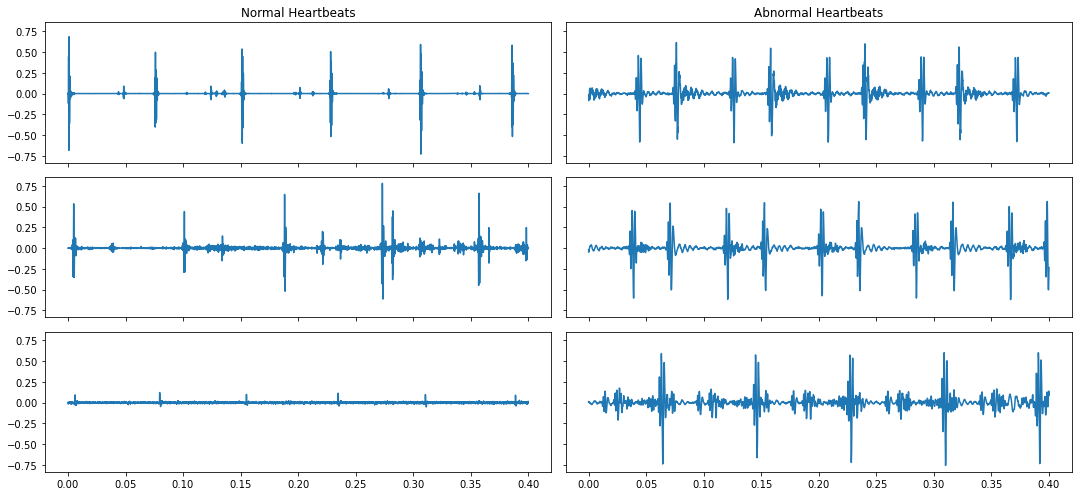

In [89]:
def show_plot_and_make_titles():
    axs[0, 0].set(title="Normal Heartbeats")
    axs[0, 1].set(title="Abnormal Heartbeats")
    plt.tight_layout()
    plt.show()
    
fig, axs = plt.subplots(3, 2, figsize=(15, 7), sharex=True, sharey=True)

# Calculate the time array
time = np.arange(len(normal)) / sfreq

# Stack the normal/abnormal audio so you can loop and plot
stacked_audio = np.hstack([normal, abnormal]).T

# Loop through each audio file / ax object and plot
# .T.ravel() transposes the array, then unravels it into a 1-D vector for looping
for iaudio, ax in zip(stacked_audio, axs.T.ravel()):
    ax.plot(time, iaudio)
show_plot_and_make_titles()

##### Conclusion : As we can see there is a lot of variability in the raw data, let's see if we can average out some of that noise to notice a difference.

### Invariance in time
- While we should always start by visualizing your raw data, this is often uninformative when it comes to discriminating between two classes of data points. Data is usually noisy or exhibits complex patterns that aren't discoverable by the naked eye.
- Another common technique to find simple differences between two sets of data is to average across multiple instances of the same class. This may remove noise and reveal underlying patterns (or, it may not).
- Task : average across many instances of each class of heartbeat sound. 

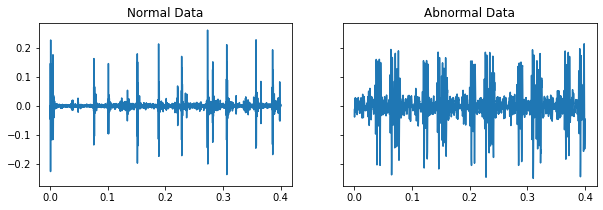

In [90]:
# Average across the audio files of each DataFrame
mean_normal = np.mean(normal, axis=1)
mean_abnormal = np.mean(abnormal, axis=1)

# Plot each average over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ax1.plot(time, mean_normal)
ax1.set(title="Normal Data")
ax2.plot(time, mean_abnormal)
ax2.set(title="Abnormal Data")
plt.show()

##### Conclusion : Do we see a noticeable difference between the two? Maybe, but it's quite noisy. Let's see how we can dig into the data a bit further.

### Build a classification model
- While eye-balling differences is a useful way to gain an intuition for the data, let's see if we can operationalize things with a model. 
- We will use each repetition as a datapoint, and each moment in time as a feature to fit a classifier that attempts to predict abnormal vs. normal heartbeats using only the raw data. 

In [102]:
from sklearn.model_selection import train_test_split

y_normal = np.full(normal.shape[0], ['normal'])
y_abnormal = np.full(abnormal.shape[0], ['abnormal'])
y = np.concatenate([y_normal, y_abnormal], axis=0)
x = np.concatenate([normal, abnormal], axis=0)

X_train, X_test, y_train, y_test = train_test_split(x, y)

In [107]:
from sklearn.svm import LinearSVC

# Initialize and fit the model
model = LinearSVC()
model.fit(X_train, y_train)

# Generate predictions and score them manually
predictions = model.predict(X_test)
print(sum(predictions == y_test.squeeze()) / len(y_test))

0.4501133786848073


##### Conclusion : Note that our predictions didn't do so well. That's because the features we're using as inputs to the model (raw data) aren't very good at differentiating classes.